<a href="https://colab.research.google.com/github/Ilanagweinstein/Kaggle-Competition/blob/master/Cadent_Sentiment_Analysis_Bert_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle Sentiment Analysis on Movie Reviews ##

**Loading transformers, data and initializing GPU**

In [0]:
!pip3 install transformers

In [0]:
import pandas as pd
import numpy as np
import os

import warnings
warnings.filterwarnings('ignore')

import transformers

In [0]:
import tensorflow as tf# Get the GPU device name.
device_name = tf.test.gpu_device_name()# The device name should look like the following:
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [0]:
import torch# If there's a GPU available...
if torch.cuda.is_available():  # Tell PyTorch to use the GPU. 
  device = torch.device("cuda") 
  print('There are %d GPU(s) available.' % torch.cuda.device_count()) 
  print('We will use the GPU:', torch.cuda.get_device_name(0))# If not...
else:
  print('No GPU available, using the CPU instead.')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [0]:
!pip install wget

In [0]:
! pip install -q kaggle

In [0]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [0]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [0]:
! cp kaggle.json ~/.kaggle/

In [0]:
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 68.0MB/s]
  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 85.7MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 82.9MB/s]


In [0]:
!unzip test.tsv.zip

Archive:  test.tsv.zip
  inflating: test.tsv                


In [0]:
!unzip train.tsv.zip

Archive:  train.tsv.zip
  inflating: train.tsv               


In [0]:
train = pd.DataFrame(pd.read_csv('/content/train.tsv', sep='\t'))
test = pd.DataFrame(pd.read_csv('/content/test.tsv', sep='\t'))

print('Number of training sentences: {:,}\n'.format(train.shape[0]))

Number of training sentences: 156,060



In [0]:
train.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [0]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


**Analysis of data can be found in Cadent_Sentiment_Analysis_Basic**

In [0]:
X_train = train.drop(['Sentiment'], axis=1)
y_train = train['Sentiment']

X_test = test

train_texts, train_labels = X_train['Phrase'], y_train
val_texts = X_test['Phrase']

**Data Pre-processing**

In [0]:
#The following code was adapted from this Bert-fine-tuning example by Chris McCormick and Nick Ryan
#Link: https://mccormickml.com/2019/07/22/BERT-fine-tuning/
#The same tutorial has been helpful for a current Fake Claim detection project I have been working on at NYU.

#BERT tokenizer
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
def tokenize_mask(texts):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []# For every sentence...
  attention_masks = []

  for text in texts:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    
    encoded_dict = tokenizer.encode_plus(
                        text,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 128,           # Pad & truncate all sentences. Max BERT can do is 512.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])# Print sentence 0, now as a list of IDs.
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
  
    # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  
  #print out example
  print('Original: ', texts[0])
  print('Token IDs:', input_ids[0])
  print('Attention Masks:', attention_masks[0])

  return input_ids, attention_masks

In [0]:
#Train data: tokenize, pad, mask and convert to tensors
train_inputs, train_masks = tokenize_mask(train_texts)
train_labels = torch.tensor(train_labels)

#Val data: tokenize, pad, mask and convert to tensors
val_inputs, val_masks = tokenize_mask(val_texts)

Original:  A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .
Token IDs: tensor([  101,  1037,  2186,  1997,  9686, 17695, 18673, 14313,  1996, 15262,
         3351,  2008,  2054,  2003,  2204,  2005,  1996, 13020,  2003,  2036,
         2204,  2005,  1996, 25957,  4063,  1010,  2070,  1997,  2029,  5681,
         2572, 25581,  2021,  3904,  1997,  2029,  8310,  2000,  2172,  1997,
         1037,  2466,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])
Attention Masks: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

**Pre-trained Model and Training Set-up**

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler# The DataLoader needs to know our batch size for training
batch_size = 32

# Create the DataLoader for training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)# Create the DataLoader for our validation set.

# Create the DataLoader for validation set without labels.
val_data = TensorDataset(val_inputs, val_masks)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 

model = BertForSequenceClassification.from_pretrained(
 "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
 num_labels = 5, # The number of output labels for multi-class classification. 
 output_attentions = False, # Whether the model returns attentions weights.
 output_hidden_states = False, # Whether the model returns all hidden-states.
)# Tell pytorch to run this model on the GPU.

model.cuda()

model.cuda() output removed

In [0]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
 lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
 eps = 1e-8 # args.adam_epsilon - default is 1e-8.
 )

from transformers import get_linear_schedule_with_warmup
# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
 num_warmup_steps = 0, # Default value in run_glue.py
 num_training_steps = total_steps)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

#Training#

In [0]:
import random
import numpy as np
import time

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
  
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Training Time': training_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  4,877.    Elapsed: 0:00:19.
  Batch    80  of  4,877.    Elapsed: 0:00:38.
  Batch   120  of  4,877.    Elapsed: 0:00:57.
  Batch   160  of  4,877.    Elapsed: 0:01:17.
  Batch   200  of  4,877.    Elapsed: 0:01:37.
  Batch   240  of  4,877.    Elapsed: 0:01:57.
  Batch   280  of  4,877.    Elapsed: 0:02:18.
  Batch   320  of  4,877.    Elapsed: 0:02:38.
  Batch   360  of  4,877.    Elapsed: 0:02:59.
  Batch   400  of  4,877.    Elapsed: 0:03:21.
  Batch   440  of  4,877.    Elapsed: 0:03:42.
  Batch   480  of  4,877.    Elapsed: 0:04:03.
  Batch   520  of  4,877.    Elapsed: 0:04:24.
  Batch   560  of  4,877.    Elapsed: 0:04:45.
  Batch   600  of  4,877.    Elapsed: 0:05:06.
  Batch   640  of  4,877.    Elapsed: 0:05:27.
  Batch   680  of  4,877.    Elapsed: 0:05:48.
  Batch   720  of  4,877.    Elapsed: 0:06:09.
  Batch   760  of  4,877.    Elapsed: 0:06:31.
  Batch   800  of  4,877.    Elapsed: 0:06:52.
  Batch   840  of

In [0]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Training Time
epoch,,
1,0.78,0:42:40
2,0.65,0:42:50
3,0.57,0:42:51
4,0.51,0:42:52


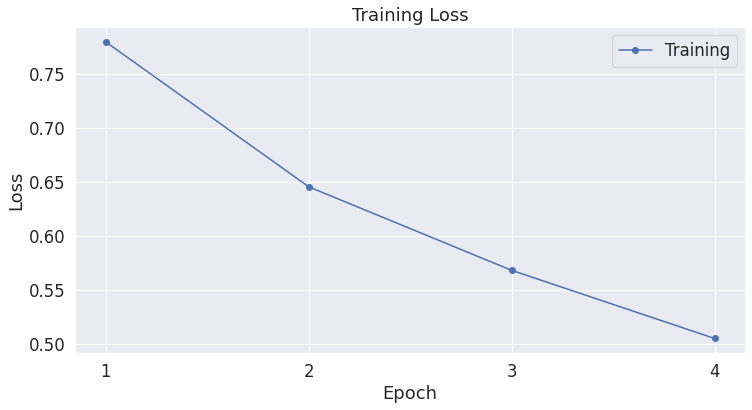

In [0]:
#We do not have validation labels t
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
# plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(val_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in val_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  # label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  # true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 66,292 test sentences...
    DONE.


In [0]:
import itertools
y_pred = []
for i in range(len(predictions)):
  
  # The predictions for this batch are a 5-column ndarray with a row for each batch (32). 
  #Pick the label with the highest value and consider the index = class
  pred_labels_i = list(np.argmax(predictions[i], axis=1))
  y_pred.append(pred_labels_i)

y_pred = list(itertools.chain.from_iterable(y_pred))
y_pred[0:5]

[2, 2, 2, 2, 2]

In [0]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


In [0]:
final = pd.DataFrame()
final['PhraseId'] = X_test['PhraseId']
final['Sentiment'] = y_pred

final.to_csv('/drive/My Drive/submission.csv', index = False)